In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functools as ft
from scipy.linalg import expm
from scipy.stats import unitary_group

# Projected mixed state ensembles

In [26]:
# Some code with functions from the projected pure ensemble file

sx = np.array([[0,1],[1,0]]) ;  sy = np.array([[0,-1j],[1j,0]])

def QIMF(N, h_x, h_y, J):

    # Single site term
    H1 = h_x * sx + h_y * sy
    # Interaction term
    H2 = J * np.kron(sx,sx)

    # Hamiltonian as a matrix
    H = np.zeros((2**N,2**N),dtype='complex128')
    for i in range(N):
        H += ft.reduce(np.kron, [np.identity(2**i), H1, np.identity(2**(N-i-1))])
    for i in range(N-2):
        H += ft.reduce(np.kron, [np.identity(2**i), H2, np.identity(2**(N-i-2))])
    
    return H

def Psi_initial(N):
    # Initial state: all |0>
    Psi0 = np.zeros(2**N)
    Psi0[0] = 1
    return Psi0

def Get_PrEns(Psi, N_A, N_B):
    PrEns = np.empty((2**N_B, 2)).tolist()

    for i in range(2**N_B):
        PsiA = Psi.reshape(2**N_A, 2**N_B)[:,i]
        PrEns[i][0] = np.linalg.norm(PsiA) ** 2
        PrEns[i][1] = PsiA / np.linalg.norm(PsiA)
    
    return PrEns

def rho_1_Haar(d):
    rho_1 = np.identity(d, dtype='complex128') / d
    return rho_1

def rho_2_Haar(d):
    rho_2 = np.zeros((d**2,d**2), dtype='complex128')
    
    # Identity
    rho_2 += np.identity(d**2, dtype='complex128')

    # Swap
    for i in range(d):
        for j in range(d):
            ket_i = np.zeros(d)
            ket_i [i] = 1
            ket_j = np.zeros(d)
            ket_j [j] = 1

            ket_ij = np.kron(ket_i, ket_j)
            ket_ji = np.kron(ket_j, ket_i)

            rho_2 += np.outer(np.conjugate(ket_ji), ket_ij)
        

    return rho_2 / (d * (d+1) )

def rho_3_Haar(d):
    rho_3 = np.zeros((d**3,d**3), dtype='complex128')

    # Identity
    rho_3 += np.identity(d**3, dtype='complex128')

    for i in range(d):
        for j in range(d):
            for k in range(d):
                ket_i = np.zeros(d)
                ket_i[i] = 1
                ket_j = np.zeros(d)
                ket_j[j] = 1
                ket_k = np.zeros(d)
                ket_k[k] = 1

                ket_ijk = ft.reduce(np.kron, [ket_i, ket_j, ket_k])

                # swaps
                ket_jik = ft.reduce(np.kron, [ket_j, ket_i, ket_k])
                ket_ikj = ft.reduce(np.kron, [ket_i, ket_k, ket_j])
                ket_kji = ft.reduce(np.kron, [ket_k, ket_j, ket_i])
                rho_3 += np.outer(np.conjugate(ket_jik), ket_ijk)
                rho_3 += np.outer(np.conjugate(ket_ikj), ket_ijk)
                rho_3 += np.outer(np.conjugate(ket_kji), ket_ijk)

                # 3-cycles
                ket_jki = ft.reduce(np.kron, [ket_j, ket_k, ket_i])
                ket_kij = ft.reduce(np.kron, [ket_k, ket_i, ket_j])
                rho_3 += np.outer(np.conjugate(ket_jki), ket_ijk)
                rho_3 += np.outer(np.conjugate(ket_kij), ket_ijk)

    return rho_3 / (d * (d+1) * (d+2))

# Moments from projected ensemble

def rho_PrEns(PrEns, k):
    
    d = np.size(PrEns[0][1])
    rho_k = np.zeros((d**k, d**k), dtype='complex128')

    for i in range(len(PrEns)):
        p_i = PrEns[i][0]
        state_i = PrEns[i][1]
        k_copies = ft.reduce(np.kron, [state_i for i in range(k)])

        rho_k += p_i * np.outer(np.conjugate(k_copies), k_copies)
    
    return rho_k



I will consider the simple case $N_A = 1, N_B = 1, N_C = 6$ as a starting case. So we get a projected ensemble as before on $A \otimes B$, with each state labelling a unique reduced density matrix. Then make it into a 'projected mixed ensemble' by tracing out B everywhere. Then directly calculate the average purity.

In [27]:
# Trial

N_A = 1
N_B = 1
N_C = 6
h_x = 0.8090
h_y = 0.9045
J = 1
N_AB = N_A + N_B

H = QIMF(N_AB + N_C, h_x, h_y, J)
Psi0 = Psi_initial(N_AB + N_C)

times = np.linspace(0,20,400)
purities = np.zeros(400, dtype='complex128')
purities[0] = 1

for i, t in enumerate(times[1:]):
    U = expm(-1j * t * H)
    Psi = U @ Psi0

    purity = 0

    for j in range(2**N_C):
        PsiAB = Psi.reshape(2**N_AB, 2**N_C)[:,j]
        p_k = np.linalg.norm(PsiAB) ** 2
        PsiAB = PsiAB / np.linalg.norm(PsiAB)
        rhoA = np.trace(np.outer(np.conjugate(PsiAB),PsiAB).reshape(2**N_A,2**N_B,2**N_A,2**N_B), axis1=1, axis2=3)
        purity += p_k * np.trace(rhoA @ rhoA)

    purities[i + 1] = purity

    




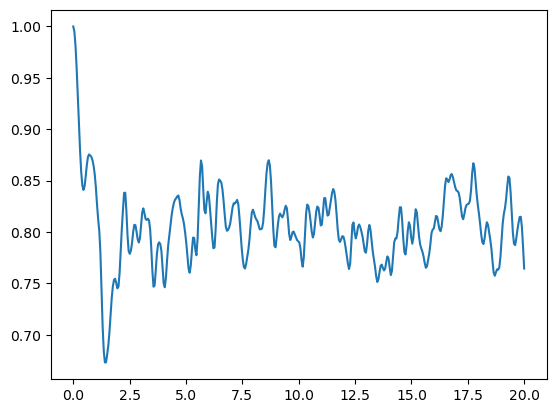

In [25]:
# Plot: it works

fig = plt.figure()

plt.plot(times, purities)
plt.show()

## Data gathering

Cell below gathers all the data in about 40-50 minutes.

In [41]:
'''
# N = 6: {1,1,4}

# Note: definition of H depends only on total dimension, so how I divide it up is irrelevant
H = QIMF(6, h_x, h_y, J)
Psi0 = Psi_initial(6)

times = np.linspace(0,50,1000)
purities_114 = np.zeros(1000, dtype='complex128')
purities_114[0] = 1

for i, t in enumerate(times[1:]):
    U = expm(-1j * t * H)
    Psi = U @ Psi0

    N_A = 1
    N_B = 1
    N_C = 4
    N_AB = N_A + N_B
    
    purity = 0

    for j in range(2**N_C):
        PsiAB = Psi.reshape(2**N_AB, 2**N_C)[:,j]
        p_k = np.linalg.norm(PsiAB) ** 2
        PsiAB = PsiAB / np.linalg.norm(PsiAB)
        rhoA = np.trace(np.outer(np.conjugate(PsiAB),PsiAB).reshape(2**N_A,2**N_B,2**N_A,2**N_B), axis1=1, axis2=3)
        purity += p_k * np.trace(rhoA @ rhoA)

    purities_114[i + 1] = purity


# N = 7: {1,1,5}, {1,2,4}, {2,1,4}

H = QIMF(7, h_x, h_y, J)
Psi0 = Psi_initial(7)

times = np.linspace(0,50,1000)
purities_115 = np.zeros(1000, dtype='complex128')
purities_115[0] = 1
purities_124 = np.zeros(1000, dtype='complex128')
purities_124[0] = 1
purities_214 = np.zeros(1000, dtype='complex128')
purities_214[0] = 1

for i, t in enumerate(times[1:]):
    U = expm(-1j * t * H)
    Psi = U @ Psi0

    # {1,1,5}
    N_A = 1
    N_B = 1
    N_C = 5
    N_AB = N_A + N_B
    
    purity = 0

    for j in range(2**N_C):
        PsiAB = Psi.reshape(2**N_AB, 2**N_C)[:,j]
        p_k = np.linalg.norm(PsiAB) ** 2
        PsiAB = PsiAB / np.linalg.norm(PsiAB)
        rhoA = np.trace(np.outer(np.conjugate(PsiAB),PsiAB).reshape(2**N_A,2**N_B,2**N_A,2**N_B), axis1=1, axis2=3)
        purity += p_k * np.trace(rhoA @ rhoA)

    purities_115[i + 1] = purity

    # {1,2,4}
    N_A = 1
    N_B = 2
    N_C = 4
    N_AB = N_A + N_B
    
    purity = 0

    for j in range(2**N_C):
        PsiAB = Psi.reshape(2**N_AB, 2**N_C)[:,j]
        p_k = np.linalg.norm(PsiAB) ** 2
        PsiAB = PsiAB / np.linalg.norm(PsiAB)
        rhoA = np.trace(np.outer(np.conjugate(PsiAB),PsiAB).reshape(2**N_A,2**N_B,2**N_A,2**N_B), axis1=1, axis2=3)
        purity += p_k * np.trace(rhoA @ rhoA)

    purities_124[i + 1] = purity

    # {2,1,4}
    N_A = 2
    N_B = 1
    N_C = 4
    N_AB = N_A + N_B
    
    purity = 0

    for j in range(2**N_C):
        PsiAB = Psi.reshape(2**N_AB, 2**N_C)[:,j]
        p_k = np.linalg.norm(PsiAB) ** 2
        PsiAB = PsiAB / np.linalg.norm(PsiAB)
        rhoA = np.trace(np.outer(np.conjugate(PsiAB),PsiAB).reshape(2**N_A,2**N_B,2**N_A,2**N_B), axis1=1, axis2=3)
        purity += p_k * np.trace(rhoA @ rhoA)

    purities_214[i + 1] = purity


# N = 8: {1,1,6}, {1,2,5}, {2,1,5}

H = QIMF(8, h_x, h_y, J)
Psi0 = Psi_initial(8)

times = np.linspace(0,50,1000)
purities_116 = np.zeros(1000, dtype='complex128')
purities_116[0] = 1
purities_125 = np.zeros(1000, dtype='complex128')
purities_125[0] = 1
purities_215 = np.zeros(1000, dtype='complex128')
purities_215[0] = 1

for i, t in enumerate(times[1:]):
    U = expm(-1j * t * H)
    Psi = U @ Psi0

    # {1,1,6}
    N_A = 1
    N_B = 1
    N_C = 6
    N_AB = N_A + N_B
    
    purity = 0

    for j in range(2**N_C):
        PsiAB = Psi.reshape(2**N_AB, 2**N_C)[:,j]
        p_k = np.linalg.norm(PsiAB) ** 2
        PsiAB = PsiAB / np.linalg.norm(PsiAB)
        rhoA = np.trace(np.outer(np.conjugate(PsiAB),PsiAB).reshape(2**N_A,2**N_B,2**N_A,2**N_B), axis1=1, axis2=3)
        purity += p_k * np.trace(rhoA @ rhoA)

    purities_116[i + 1] = purity

    # {1,2,5}
    N_A = 1
    N_B = 2
    N_C = 5
    N_AB = N_A + N_B
    
    purity = 0

    for j in range(2**N_C):
        PsiAB = Psi.reshape(2**N_AB, 2**N_C)[:,j]
        p_k = np.linalg.norm(PsiAB) ** 2
        PsiAB = PsiAB / np.linalg.norm(PsiAB)
        rhoA = np.trace(np.outer(np.conjugate(PsiAB),PsiAB).reshape(2**N_A,2**N_B,2**N_A,2**N_B), axis1=1, axis2=3)
        purity += p_k * np.trace(rhoA @ rhoA)

    purities_125[i + 1] = purity

    # {2,1,5}
    N_A = 2
    N_B = 1
    N_C = 5
    N_AB = N_A + N_B
    
    purity = 0

    for j in range(2**N_C):
        PsiAB = Psi.reshape(2**N_AB, 2**N_C)[:,j]
        p_k = np.linalg.norm(PsiAB) ** 2
        PsiAB = PsiAB / np.linalg.norm(PsiAB)
        rhoA = np.trace(np.outer(np.conjugate(PsiAB),PsiAB).reshape(2**N_A,2**N_B,2**N_A,2**N_B), axis1=1, axis2=3)
        purity += p_k * np.trace(rhoA @ rhoA)

    purities_215[i + 1] = purity

# N = 9: {1,1,7}, {1,2,6}, {2,1,6}

H = QIMF(9, h_x, h_y, J)
Psi0 = Psi_initial(9)

times = np.linspace(0,50,1000)
purities_117 = np.zeros(1000, dtype='complex128')
purities_117[0] = 1
purities_126 = np.zeros(1000, dtype='complex128')
purities_126[0] = 1
purities_216 = np.zeros(1000, dtype='complex128')
purities_216[0] = 1

for i, t in enumerate(times[1:]):
    U = expm(-1j * t * H)
    Psi = U @ Psi0

    # {1,1,7}
    N_A = 1
    N_B = 1
    N_C = 7
    N_AB = N_A + N_B
    
    purity = 0

    for j in range(2**N_C):
        PsiAB = Psi.reshape(2**N_AB, 2**N_C)[:,j]
        p_k = np.linalg.norm(PsiAB) ** 2
        PsiAB = PsiAB / np.linalg.norm(PsiAB)
        rhoA = np.trace(np.outer(np.conjugate(PsiAB),PsiAB).reshape(2**N_A,2**N_B,2**N_A,2**N_B), axis1=1, axis2=3)
        purity += p_k * np.trace(rhoA @ rhoA)

    purities_117[i + 1] = purity

    # {1,2,6}
    N_A = 1
    N_B = 2
    N_C = 6
    N_AB = N_A + N_B
    
    purity = 0

    for j in range(2**N_C):
        PsiAB = Psi.reshape(2**N_AB, 2**N_C)[:,j]
        p_k = np.linalg.norm(PsiAB) ** 2
        PsiAB = PsiAB / np.linalg.norm(PsiAB)
        rhoA = np.trace(np.outer(np.conjugate(PsiAB),PsiAB).reshape(2**N_A,2**N_B,2**N_A,2**N_B), axis1=1, axis2=3)
        purity += p_k * np.trace(rhoA @ rhoA)

    purities_126[i + 1] = purity

    # {2,1,6}
    N_A = 2
    N_B = 1
    N_C = 6
    N_AB = N_A + N_B
    
    purity = 0

    for j in range(2**N_C):
        PsiAB = Psi.reshape(2**N_AB, 2**N_C)[:,j]
        p_k = np.linalg.norm(PsiAB) ** 2
        PsiAB = PsiAB / np.linalg.norm(PsiAB)
        rhoA = np.trace(np.outer(np.conjugate(PsiAB),PsiAB).reshape(2**N_A,2**N_B,2**N_A,2**N_B), axis1=1, axis2=3)
        purity += p_k * np.trace(rhoA @ rhoA)

    purities_216[i + 1] = purity


# N = 10: {1,1,8}, {1,2,7}, {2,1,7}

H = QIMF(10, h_x, h_y, J)
Psi0 = Psi_initial(10)

times_short = np.linspace(0,50,400)
purities_118 = np.zeros(400, dtype='complex128')
purities_118[0] = 1
purities_127 = np.zeros(400, dtype='complex128')
purities_127[0] = 1
purities_217 = np.zeros(400, dtype='complex128')
purities_217[0] = 1

for i, t in enumerate(times_short[1:]):
    U = expm(-1j * t * H)
    Psi = U @ Psi0

    # {1,1,8}
    N_A = 1
    N_B = 1
    N_C = 8
    N_AB = N_A + N_B
    
    purity = 0

    for j in range(2**N_C):
        PsiAB = Psi.reshape(2**N_AB, 2**N_C)[:,j]
        p_k = np.linalg.norm(PsiAB) ** 2
        PsiAB = PsiAB / np.linalg.norm(PsiAB)
        rhoA = np.trace(np.outer(np.conjugate(PsiAB),PsiAB).reshape(2**N_A,2**N_B,2**N_A,2**N_B), axis1=1, axis2=3)
        purity += p_k * np.trace(rhoA @ rhoA)

    purities_118[i + 1] = purity

    # {1,2,7}
    N_A = 1
    N_B = 2
    N_C = 7
    N_AB = N_A + N_B
    
    purity = 0

    for j in range(2**N_C):
        PsiAB = Psi.reshape(2**N_AB, 2**N_C)[:,j]
        p_k = np.linalg.norm(PsiAB) ** 2
        PsiAB = PsiAB / np.linalg.norm(PsiAB)
        rhoA = np.trace(np.outer(np.conjugate(PsiAB),PsiAB).reshape(2**N_A,2**N_B,2**N_A,2**N_B), axis1=1, axis2=3)
        purity += p_k * np.trace(rhoA @ rhoA)

    purities_127[i + 1] = purity

    # {2,1,7}
    N_A = 2
    N_B = 1
    N_C = 7
    N_AB = N_A + N_B
    
    purity = 0

    for j in range(2**N_C):
        PsiAB = Psi.reshape(2**N_AB, 2**N_C)[:,j]
        p_k = np.linalg.norm(PsiAB) ** 2
        PsiAB = PsiAB / np.linalg.norm(PsiAB)
        rhoA = np.trace(np.outer(np.conjugate(PsiAB),PsiAB).reshape(2**N_A,2**N_B,2**N_A,2**N_B), axis1=1, axis2=3)
        purity += p_k * np.trace(rhoA @ rhoA)

    purities_217[i + 1] = purity


np.savez('Purity_timeseries',
         times=times,
         times_short=times_short,
         purities_114=purities_114,
         purities_115=purities_115,
         purities_116=purities_116,
         purities_117=purities_117,
         purities_118=purities_118,
         purities_214=purities_214,
         purities_215=purities_215,
         purities_216=purities_216,
         purities_217=purities_217,
         purities_124=purities_124,
         purities_125=purities_125,
         purities_126=purities_126,
         purities_127=purities_127)


'''

## More data: empirical Haar



In [64]:
U = unitary_group.rvs(4)
print(U)

Psi0 = Psi_initial(4)
print(Psi0)

[[ 0.43288894+0.4691636j   0.45363548-0.57894186j  0.1997022 -0.08895966j
  -0.0333355 -0.05126206j]
 [-0.2833902 -0.59031218j  0.31559271-0.32614111j  0.50480835+0.19341777j
   0.20106071+0.1805199j ]
 [-0.09050373-0.29213439j  0.33434293-0.18279512j -0.5563204 -0.04509148j
   0.20644459-0.63806138j]
 [ 0.16997853+0.20319468j -0.32762678+0.02314792j  0.22346897+0.54635089j
   0.60145689-0.33429929j]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [65]:
# N_A = 1, N_B = 1

purity_11 = 0

for i in range(100):
    Psi0 = Psi_initial(2)
    U = unitary_group.rvs(4)
    Psi = U @ Psi0

    rhoA = np.trace(np.outer(np.conjugate(Psi), Psi).reshape(2,2,2,2), axis1=1, axis2=3)

    purity_11 += np.trace(rhoA @ rhoA)

purity_11 /= 100

purity_12 = 0
purity_21 = 0

for i in range(100):
    Psi0 = Psi_initial(3)
    U = unitary_group.rvs(8)
    Psi = U @ Psi0

    rhoA = np.trace(np.outer(np.conjugate(Psi), Psi).reshape(2,4,2,4), axis1=1, axis2=3)
    purity_12 += np.trace(rhoA @ rhoA)

    rhoA = np.trace(np.outer(np.conjugate(Psi), Psi).reshape(4,2,4,2), axis1=1, axis2=3)
    purity_21 += np.trace(rhoA @ rhoA)

purity_12 /= 100
purity_21 /= 100

## Plots and analysis

/Users/DaanTimmers/anaconda3/envs/py311/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


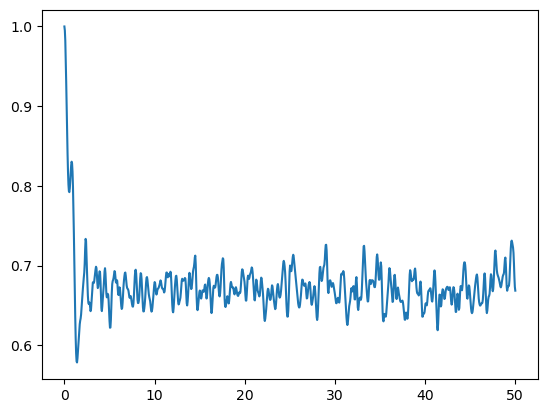

In [58]:
purity_timeseries = np.load('Purity_timeseries.npz')

fig = plt.figure()
plt.plot(purity_timeseries['times'], purity_timeseries['purities_126'])
plt.show()